In [3]:
import sys
import os
import cobra
import cplex 
import libsbml
import pandas as pd
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import csv
import numpy as np
import seaborn as sns
from cobra import Reaction


#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src")

import model_initialize as model_init
import model_manipulation  as mm


In [4]:
config = cobra.Configuration()

config.solver = 'gurobi'

In [5]:
#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6
#Set model solver

trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")


Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-09


In [6]:
#This codeblock is to define some of the functions used for modelling

##UPDATED JULY 28 2023

##NOTES:
##Fixed wrong encoding of reactions for Malate dehydrogenase as well as NADP ME.



#Define linear relationship between PPFD and Cellular maintainance costs
#This formula comes from Topfer et al (2020) where she defined NGAM in a linear relationship with incident light
inf=1e6

def generate_constraint(model,reaction, name, lb, ub):
    reaction_fex = model.reactions.get_by_id(name).flux_expression
    constraint = model.problem.Constraint(reaction_fex, lb=lb, ub=ub)
    constraint.name = name + '_constraint'
    model.add_cons_vars

def compute_ngam_atp(ppfd):
    v_atp = 0.0049*ppfd + 2.7851
    return v_atp


#This function is used to set the inputs to the model used. 
def define_model_medium(model, co2, o2, ppfd, 
                        medium_dir='./misc/photo_medium.csv', no3=inf, h2o=inf, h=inf, 
                        nh4=inf, pi=inf):
    model_photo_media = mm.read_medium_csv(medium_dir, model)
    model_photo_media['EX_no3(e)'] = no3
    model_photo_media['EX_h2o(e)'] = h2o
    model_photo_media['EX_h(e)'] = h
    model_photo_media['EX_nh4(e)'] = nh4
    model_photo_media['EX_co2(e)'] = co2
    model_photo_media['EX_o2(e)'] = o2
    model_photo_media['EX_photonVis(e)'] = ppfd
    model_photo_media['EX_pi(e)'] = pi
    #Set set model medium as model
#     print('Added model medium')
    return model_photo_media

    
def turn_off_cofac_cycles(model, inact_dir='./misc/leaf_inactivated.tsv'):
    file = csv.reader(open(inact_dir), delimiter='\t')
    leaf_inactive_rxns = list()
    for rows in file:
        row_m = str()
        row_bs = str()
        for rxns in rows:
            row_m += str(rxns) + "_M"
            row_bs += str(rxns) + "_BS"
        leaf_inactive_rxns.append(row_m)
        leaf_inactive_rxns.append(row_bs)
        
    for rxns in model.reactions:
        if rxns.id in leaf_inactive_rxns:
            rxns.bounds = (0,0)
#     print('Successfully turned off cofactor-cycling reactions')

    
# #Add constraints to model
#This code block contains constraints that would simulate the assimilation rates of bs and m cells in a two-cell system (such as those seen near the midvein region of rice leaves)
# #BS photon flux must be the same/less than M flux (Adapted from B&B, 2019)
# photon_import = model.reactions.get_by_id("EX_photonVis(e)")
def add_tissue_constraints(model):
    #For input fluxes for light, we will set the flux ratio to 10:1 to reflect the anatomical proportions of our model ()
    
    BS_photon_import = model.reactions.PRISM_white_LED_BS
    M_photon_import = model.reactions.PRISM_white_LED_M

    #Set photon flux ratio to 10:1
    photon_flux = mm.set_fix_flux_ratio({M_photon_import.id:10, BS_photon_import.id:1},model)
    model.add_cons_vars(photon_flux)

    
    #UPDATE: Change CO2 intake to the M Cell instead rather than set a ratio, which is a better assumption overall. Assume na lang that external gasses are assimilated
    #Via the M cell.
    #From Morrison et al 2005 -- Lateral diffusion of Gases is unlikely to support photosynthesis due to the
    #assimilation of diffused CO2 in tissues prior to BS//
    model.reactions.CO2tex_BS.bounds = (0,0)
    model.reactions.O2tex_BS.bounds = (0,0)
    
    #UPDATE: This assumption does not hold considering that recent transcriptomic analysis confirms that 
    #the bundle sheath is involved in the assimilation of inorganic nutrients, including nitrogen (nitrates/ammonia), and 
    #Sulfates. In turn, this will be implemented by simply setting the exchanges to the M cell to 0. (Hua et al, 2021)
    model.reactions.SO3tex_M.bounds = (0,0)
    model.reactions.SO4tex_M.bounds = (0,0)
    model.reactions.NH4tex_M.bounds = (0,0)
    model.reactions.NO3tex_M.bounds = (0,0)
    
    #Model will also constraint H2O input to BS cell only as it is also assumed that BS tissue in rice is specialized for H2O transport (Hua et al. 2021)
    #There is a demand reaction naman for H2O for the M cell which is not connected to the BS H2Otex
    #Restrict H2O transport to be unidirectional from the BS cell
    model.reactions.H2Otex_M.bounds = (0, 0)
    model.reactions.h2o_pd.bounds = (-inf, 0)
    
    #need to turn off HCO import as the model incorrectly transfers fixed HCO to the BS cell via the common pool compartment
    model.reactions.HCO3tex_M.bounds = (0,0)
    model.reactions.HCO3tex_BS.bounds = (0,0)
    
    #Turn off extracellular Glycine transport 
    model.reactions.GLYtex_M.bounds = (0,0)
    model.reactions.GLYtex_BS.bounds = (0,0)
    
    #Turn off other Demand reactions that may serve as sinks for the model except DM_Phloem_BS (Which represents the output of photoassimilate thru the BS cell
    model.reactions.DM_Phloem_M.bounds = (0,0)
    model.reactions.Straw_Biomass_M.bounds = (0,0)
    model.reactions.Straw_Biomass_BS.bounds = (0,0)
    model.reactions.Coleoptile_Biomass_M.bounds = (0,0)
    model.reactions.Coleoptile_Biomass_BS.bounds = (0,0)
    model.reactions.DM_Phloem_BS.bounds = (0, inf)
    

def add_enzyme_constraints(model, 
                           wt_pepc = 0, 
                           wt_mdh = 11.18, 
                           wt_nadp_me = 0.14, 
                           wt_ppdk=0.31,
                          wt_CA=7.5):
    
    
    # #This code block contains constraints specific for enzyme rate constraints
    #This approach is derived from Bogart & Myers (2016) where they constrained the enzyme rate 
    #fluxes in each of the 2-cell segments to a specific upper bound while keeping the lower bound
    #At 0. For reversible reactions the lower bounds are set to the same value
    
    
    #PEPC constraint (Reaction id: PPCc)
    #Need to constrain it to 0 since reaction is only detected in Vascular tissue
    pepc_BS = model.reactions.PPCc_BS
    pepc_M = model.reactions.PPCc_M
    
    pepc_BS.bounds = (0,0)
    pepc_M.bounds = (0,0)

    #PPDK constraints (Reaction id: PPDKs) (note that this is found in the chloroplast?) 
    #Not detected via immunolocalization but enzyme activity is detected

    ppdks_BS = model.reactions.PPDKs_BS
    ppdks_M = model.reactions.PPDKs_M
    ppdkc_BS = model.reactions.PPDKc_BS
    ppdkc_M = model.reactions.PPDKc_M
    wt_ppdks_cons = model.problem.Constraint(ppdks_BS.flux_expression 
                                             + ppdks_M.flux_expression
                                             + ppdkc_BS.flux_expression
                                             + ppdkc_M.flux_expression, 
                                             lb = 0, ub = wt_ppdk)
    wt_ppdks_cons.name = 'wt_ppdks_cons'
    model.add_cons_vars(wt_ppdks_cons)
    
    
    #Malate Dehydrogenase 
    #Only mitochondrial in WT Rice M cells
    model.reactions.MDHs_M.bounds = (0,0)
    model.reactions.MDHc_M.bounds = (0,0)
    model.reactions.MDHx_M.bounds = (0,0)
    model.reactions.MDHs_BS.bounds = (0,0)
    model.reactions.MDHc_BS.bounds = (0,0)
    model.reactions.MDHx_BS.bounds = (0,0)
    
    #Add constraints to MDHm
    mdhm_M = model.reactions.MDHm_M
    
    wt_mdh_cons = model.problem.Constraint(mdhm_M.flux_expression,
                                           lb= -wt_mdh, ub=wt_mdh)
    wt_mdh_cons.name = "wt_mdh_cons"
    model.add_cons_vars(wt_mdh_cons)

    #NADP-ME (Since no signal is detected in WT, no locational constraints are imposed)
    #Let's see if I can force it to have a small amount of flux 
    mdh2s_M = model.reactions.MDH2s_M
    mdh2s_BS = model.reactions.MDH2s_BS
    mdh2c_M = model.reactions.MDH2s_M
    mdh2c_BS = model.reactions.MDH2s_BS


    wt_nadpme_cons = model.problem.Constraint(mdh2s_M.flux_expression
                                             + mdh2s_BS.flux_expression
                                              + mdh2c_M.flux_expression
                                              + mdh2c_BS.flux_expression,
                                             lb= 0, ub=wt_nadp_me)
    wt_nadpme_cons.name = "wt_nadpme_cons"
    model.add_cons_vars(wt_nadpme_cons)


    #I should add constraints for Carbonic Anhydrase
    #I should constrain it to 0.4 ubar, which would constitute ambient CO2 partial pressure
    #Flux is reversible so constraints are bi-directional
    #This should be revised considering that it allows reversible reactions  and an abnormally high flux thru carbonic anhydrase, which shouldn't be the case

    hco3es_m = model.reactions.HCO3Es_M.flux_expression
    hco3ec_m = model.reactions.HCO3Ec_M.flux_expression
    hco3em_m = model.reactions.HCO3Em_M.flux_expression
    hco3es_bs = model.reactions.HCO3Es_BS.flux_expression
    hco3ec_bs = model.reactions.HCO3Ec_BS.flux_expression
    hco3em_bs = model.reactions.HCO3Em_BS.flux_expression

    ca_cons = model.problem.Constraint(hco3es_m + hco3ec_m + hco3em_m 
                                       + hco3es_bs + hco3ec_bs + hco3em_bs,
                                      lb = -wt_CA, ub = wt_CA)
    ca_cons.name = 'Carbonic_anhydrase_constraint'
    model.add_cons_vars(ca_cons)


    #Rbcl constaints
    #Retrieve flux expressions oof each RBCl reaction
    rbpc_M = model.reactions.RBPCs_M.flux_expression
    rbpc_BS = model.reactions.RBPCs_BS.flux_expression
    rbpo_M = model.reactions.RBPOs_M.flux_expression
    rbpo_BS = model.reactions.RBPOs_BS.flux_expression

    #Constraint such that it is limited to 132 umol m-2 s-1
    rbcl_vcmax_cons = model.problem.Constraint(rbpc_M + rbpc_BS, lb = 0, ub= 132)
    rbcl_vcmax_cons.name='rbcl_vcmax_cons'
    model.add_cons_vars(rbcl_vcmax_cons)
    #Constraints for rbcl flux such that v_c/v_o = 3 or higher.
    rbcl_vcvo = model.problem.Constraint(3*(rbpo_M + rbpo_BS) 
                                         - 1*(rbpc_M + rbpc_BS),
                                         lb=0,ub=1000)
    rbcl_vcvo.name = 'rbcl_vc/vo_ratio'
    model.add_cons_vars(rbcl_vcvo)

    #Turn off the RBPC2s reactions since we already defined the constraints above
    model.reactions.RBPC2s_M.bounds = (0,0)
    model.reactions.RBPC2s_BS.bounds = (0,0)
    
    
    
    #What if I simply constrained that of the M cell one to 3:1?
    #This constraint is pretty good actually. 
    #This allows the system to be set at a specific Vc/Vo rate while still allowing local variation 
    #wherein Rubisco may act in an uncoupled fashion and may have favorable internal vc/vo rates.
# #This code block is to set a constraint such that M-to-BS cell NGAM ratio is 10-to-1 
# #Similar to what Moreno-Villena et al (2022) had done 

#This function takes two arguments: the model and the maximal  ppfd input to the system
def add_ngam_cons(model, ppfd): 
    ngam_atp_m = mm.get_rxn(model, 'ngam_atp_c_M')
    ngam_atp_bs = mm.get_rxn(model, 'ngam_atp_c_BS')
    ngam_atp_m.bounds = (0,inf)
    ngam_atp_bs.bounds = (0,inf)
    ngam_ratio = mm.set_fix_flux_ratio({ngam_atp_m.id:10, ngam_atp_bs.id:1}, model)
    ngam_ratio.name = 'ngam_BS/M_ratio'
    model.add_cons_vars(ngam_ratio)

    #Retrieve NGAM reactions
    ngam_nadphox_c_M = mm.get_rxn(model, 'ngam_nadphox_c_M')
    ngam_nadphox_s_M = mm.get_rxn(model, 'ngam_nadphox_s_M')
    ngam_nadphox_m_M = mm.get_rxn(model, 'ngam_nadphox_m_M')
    ngam_nadphox_c_BS = mm.get_rxn(model, 'ngam_nadphox_c_BS')
    ngam_nadphox_s_BS = mm.get_rxn(model, 'ngam_nadphox_s_BS')
    ngam_nadphox_m_BS = mm.get_rxn(model, 'ngam_nadphox_m_BS')


    #Set Fixed fluxes
    nadphox_c_s_M = mm.set_fix_flux_ratio({ngam_nadphox_c_M.id:1, ngam_nadphox_s_M.id:1},model)
    nadphox_c_s_M.name = "nadphox_cs_ratio_M"
    nadphox_s_m_M = mm.set_fix_flux_ratio({ngam_nadphox_s_M.id:1, ngam_nadphox_m_M.id:1}, model)
    nadphox_s_m_M.name = "nadphox_sm_ratio_M"

    nadphox_c_s_BS = mm.set_fix_flux_ratio({ngam_nadphox_c_BS.id:1, ngam_nadphox_s_BS.id:1},model)
    nadphox_c_s_BS.name = "nadphox_cs_ratio_BS"
    nadphox_s_m_BS = mm.set_fix_flux_ratio({ngam_nadphox_s_BS.id:1, ngam_nadphox_m_BS.id:1}, model)
    nadphox_s_m_BS.name = "nadphox_sm_ratio_BS"

    #Add constraints
    model.add_cons_vars(nadphox_c_s_M)
    model.add_cons_vars(nadphox_s_m_M)
    model.add_cons_vars(nadphox_c_s_BS)
    model.add_cons_vars(nadphox_s_m_BS)

    #Retrieve flux expressionns
    fex_nadphox_c_M =  mm.get_flux_exp(model, ngam_nadphox_c_M)
    fex_nadphox_s_M = mm.get_flux_exp(model, ngam_nadphox_s_M)
    fex_nadphox_m_M = mm.get_flux_exp(model, ngam_nadphox_m_M)

    fex_nadphox_c_BS =  mm.get_flux_exp(model, ngam_nadphox_c_BS)
    fex_nadphox_s_BS =  mm.get_flux_exp(model, ngam_nadphox_s_BS)
    fex_nadphox_m_BS =  mm.get_flux_exp(model, ngam_nadphox_m_BS)

    fex_atp_c_M = mm.get_flux_exp(model, ngam_atp_m)
    fex_atp_c_BS =  mm.get_flux_exp(model, ngam_atp_bs)

    #Set the constraint between ATP:NADPH NGAM to 3:1
    nadphox_atpase = model.problem.Constraint(3*(fex_nadphox_c_M + fex_nadphox_s_M + fex_nadphox_m_M
                                                       + fex_nadphox_c_BS + fex_nadphox_s_BS + fex_nadphox_m_BS) 
                                         - 1*(fex_atp_c_M + fex_atp_c_BS),
                                         lb=0,ub=0)
    nadphox_atpase.name = "nadphox_atpase_ratio"
    model.add_cons_vars(nadphox_atpase)
    #Compute NGAM value and add constraint as a lower bound/upper bound to model
    ngam_value = compute_ngam_atp(ppfd)
    ngam_cons = model.problem.Constraint(fex_atp_c_M + 
                                        fex_atp_c_BS, lb=ngam_value, ub=ngam_value)
    ngam_cons.name = 'NGAM_ATP_constraint'
    model.add_cons_vars(ngam_cons)
    
#This code  block gives a snapshot of the relevant fluxes on each of the cell types based on the saved sample_fluxes values above

def print_summary(model, sample_fluxes_df):
    print('rbcl M cell: ', sample_fluxes['RBPCs_M'], 'rbcl BS cell: ',sample_fluxes['RBPCs_BS'])
    print('rbcl M cell (photorespiration)', sample_fluxes['RBPOs_M'], 'rbcl BS cell (PR)', sample_fluxes['RBPOs_BS'])
    print('vc/vo M:', sample_fluxes['RBPCs_M']/sample_fluxes['RBPOs_M'], 'vc/vo BS:', sample_fluxes['RBPCs_BS']/sample_fluxes['RBPOs_BS'])
    print('RBPC2s_M', sample_fluxes['RBPC2s_M'], 'RBPC2s_BS', sample_fluxes['RBPC2s_BS'])
    print('PEPC M', sample_fluxes['PPCc_M'], 'PEPC BS', sample_fluxes['PPCc_BS'])
    print('Carbonic Anhydrase (Cytosolic) M', sample_fluxes['HCO3Ec_M'], 'Carbonic Anhydrase (Cytosolic) BS', sample_fluxes['HCO3Ec_BS'])
    print('NADP-ME M', sample_fluxes['MDHys_M'], 'NADP-ME BS', sample_fluxes['MDHys_BS'])
    print('Biomass M: ', sample_fluxes['Straw_Biomass_M'], 'Biomass BS', sample_fluxes['Straw_Biomass_BS'])
    print('Phloem M: ', sample_fluxes['DM_Phloem_M'], 'Phloem BS', sample_fluxes['DM_Phloem_BS'])
    print('co2 consumption M', sample_fluxes['CO2tex_M'], 'co2 consumption BS', sample_fluxes['CO2tex_BS'])
    print('o2 consumption M', sample_fluxes['O2tex_M'], 'o2 consumption BS', sample_fluxes['O2tex_BS'])
    print('Photosystem II M', sample_fluxes['PSIINC_M'], 'PSII BS', sample_fluxes['PSIINC_BS'])
    print('PSI M', sample_fluxes['PSIMR_M'], 'PSI BS', sample_fluxes['PSIMR_BS'])
    print('PPFD M: ', sample_fluxes['PRISM_white_LED_M'], 'PPFD BS: ', sample_fluxes['PRISM_white_LED_BS'])
    print('ATP synthesis (stromal) M', sample_fluxes['ATPSs_M'], 'ATP synthase (mit) M', sample_fluxes['ATPSm_M'])
    pd_rxn = [x for x in model.reactions if "pd" in x.id and "h2o" not in x.id]
    pd_abs_flux = 0
    for pds in pd_rxn:
        pd_abs_flux += abs(sample_fluxes[pds.id])
    
    print('pd_abs_flux: ', pd_abs_flux)
    
#initialize list of transgenic reactions to add  to model

def add_trans_reactions(model):
    '''
    This function is used to add a number of new tissue-specific reactions that were not present in the
    original model to facilitate modelling of the transgenic C4 rice
    '''
    trans_list = list()
    #Transgenic PEPC copy
    #PEPC = Chloroplastic in M & V (rxn id: PPCc)
    trans_ppcs = Reaction('trans_PPCs_M')
    trans_ppcs.name = "Phosphoenolpyruvate carboxylase, plastidic (Transgenic)"
    
    pep_s0 = model.metabolites.pep_s0
    hco3_s0 = model.metabolites.hco3_s0
    oaa_s0 = model.metabolites.oaa_s0
    pi_s0 = model.metabolites.pi_s0


    #Add metabolites, bounds, and subsystem
    trans_ppcs.add_metabolites({hco3_s0:-1, pep_s0:-1, oaa_s0:1, pi_s0:1})
    trans_ppcs.bounds= model.reactions.PPCc_M.bounds
    trans_ppcs.subsystem = model.reactions.PPCc_M.subsystem

    trans_list.append(trans_ppcs)


    #Transgenic PPDK Copy
    trans_ppdks_m = Reaction('trans_PPDKs_M')
    trans_ppdks_m.add_metabolites(model.reactions.PPDKs_M.metabolites)
    trans_ppdks_m.bounds = model.reactions.PPDKs_M.bounds
    trans_ppdks_m.name = "Pyruvate phosphate dikinase, plastidic (Transgenic)"

    trans_ppdks_bs = Reaction('trans_PPDKs_BS')
    trans_ppdks_bs.add_metabolites(model.reactions.PPDKs_BS.metabolites)
    trans_ppdks_bs.bounds = model.reactions.PPDKs_BS.bounds
    trans_ppdks_bs.name = "Pyruvate phosphate dikinase, plastidic (Transgenic)"

    trans_list.append(trans_ppdks_m)
    trans_list.append(trans_ppdks_bs)

    #Transgenic NADP-ME
    #NADP-ME = Mitochondrial in M
    trans_nadp_me = Reaction('trans_MDH2m_M')

    #retrieve reactants
    mal_m0 = model.metabolites.get_by_id('mal-L_m0')
    nadp_m0 = model.metabolites.nadp_m0
    co2_m0 = model.metabolites.co2_m0
    nadph_m0 = model.metabolites.nadph_m0
    pyr_m0 = model.metabolites.pyr_m0

    #Add to rxn
    trans_nadp_me.add_metabolites({mal_m0:-1, nadp_m0:-1, co2_m0:1, nadph_m0:1, pyr_m0:1})
    #Add bounds
    trans_nadp_me.bounds=(-inf, inf)

    trans_list.append(trans_nadp_me)

    
    #July 28, 2023
    #Not needed anymore aas I've instead rebased the constraint to use the original reactions instead.
#     #Malate Dehydrogenase, mitochondrial (M cell)
#     trans_MDHm_M = Reaction('trans_MDHm_M')
#     trans_MDHm_M.name = 'Malate Dehydrogenase, Mitochondrial'
#     trans_MDHm_M.add_metabolites(model.reactions.MDHm_M.metabolites)
#     trans_MDHm_M.subsystem = model.reactions.MDHm_M.subsystem
#     trans_MDHm_M.notes['SUBSYSTEM'] = trans_MDHm_M.subsystem

#     trans_list.append(trans_MDHm_M)

#     #Malate dehydrogenase, plastidic (M cell)
#     trans_MDHs_M = Reaction('trans_MDHs_M')
#     trans_MDHs_M.name = 'Malate Dehydrogenase, Plastidic'
#     trans_MDHs_M.add_metabolites(model.reactions.MDHs_M.metabolites)
#     trans_MDHs_M.subsystem = model.reactions.MDHs_M.subsystem
#     trans_MDHs_M.notes['SUBSYSTEM'] = trans_MDHs_M.subsystem
#     trans_list.append(trans_MDHs_M)

#     #Malate dehydrogenase, plastidic(BS Cell)
#     trans_MDHs_BS = Reaction('trans_MDHs_BS')
#     trans_MDHs_BS.name = 'Malate Dehydrogenase, Plastidic'
#     trans_MDHs_BS.add_metabolites(model.reactions.MDHs_BS.metabolites)
#     trans_MDHs_BS.subsystem = model.reactions.MDHs_BS.subsystem
#     trans_MDHs_BS.notes['SUBSYSTEM'] = trans_MDHs_BS.subsystem

#     trans_list.append(trans_MDHs_BS)


    #Trans CA
    #Cytosolic in M
    trans_hco3ec_M = Reaction('trans_hco3ec_M')
    trans_hco3ec_M.name = 'carbonic anhydrase, cytosolic'
    trans_hco3ec_M.add_metabolites(model.reactions.HCO3Ec_M.metabolites)
    trans_hco3ec_M.bounds = model.reactions.HCO3Ec_M.bounds

    trans_hco3ec_M.subsystem = model.reactions.HCO3Ec_M.subsystem
    trans_list.append(trans_hco3ec_M)


    #Bulk add to model
    model.add_reactions(trans_list)
    
    model.repair()
####ADDING TRANS CONSTRAINTS

def add_trans_constraints(model,
                         trans_pepc_rates = 7.01,
                         trans_ppdks_rates = 3.66,
                         trans_mdh_rates = 152.87,
                         trans_nadp_me_rates = 0.60,
                         trans_CA_rates = 8):
    '''
    This function is used to add another layer of constraints to parametize model based on the
    Enzyme reaction rates assayed from Ermakova et al (2021) where the locations are based on the 
    each of the transgenic enzyme's tissue-specific localizations. 
    '''
    
    #PEPC constraint
    wt_PPCc_M = mm.get_rxn(model, 'PPCc_M')
    wt_PPCc_BS = mm.get_rxn(model, 'PPCc_BS')
    trans_PPCs_M = mm.get_rxn(model, 'trans_PPCs_M')                           
    trans_PEPC_cons = model.problem.Constraint(trans_PPCs_M.flux_expression
                                            +wt_PPCc_BS.flux_expression 
                                            + wt_PPCc_M.flux_expression, 
                                            lb = 0, ub = trans_pepc_rates)

    model.add_cons_vars(trans_PEPC_cons)

    #PPDK constraint
    trans_PPDKs_M  = mm.get_rxn(model, 'trans_PPDKs_M')
    trans_PPDKs_BS = mm.get_rxn(model, 'trans_PPDKs_BS')
    wt_PPDKs_M = mm.get_rxn(model, 'PPDKs_M')
    wt_PPDKs_BS = mm.get_rxn(model, 'PPDKs_BS')
    
    trans_PPDKs_cons = model.problem.Constraint( 
        trans_PPDKs_BS.flux_expression + trans_PPDKs_M.flux_expression 
        +wt_PPDKs_BS.flux_expression + wt_PPDKs_M.flux_expression, 
                                             lb = 0, ub = trans_ppdks_rates)
    trans_PPDKs_cons.name = 'trans_ppdks_cons'
    model.add_cons_vars(trans_PPDKs_cons)
    


    #Malate Dehydrogenase Constraints
    trans_MDHm_M = mm.get_rxn(model, 'MDHm_M')
    trans_MDHs_M = mm.get_rxn(model, 'MDHs_M')
    trans_MDHs_BS = mm.get_rxn(model, 'MDHs_BS')
    
    #Change bounds to reflect the Trans state (Based on Immunoblotting)
    trans_MDHm_M.bounds = (-inf, inf)
    trans_MDHs_M.bounds = (-inf, inf)
    trans_MDHs_BS.bounds = (-inf, inf)
    
    trans_mdh_cons =  model.problem.Constraint(
       trans_MDHm_M.flux_expression + 
        trans_MDHs_M.flux_expression + 
        trans_MDHs_BS.flux_expression, 
        lb= -trans_mdh_rates, ub=trans_mdh_rates)

    trans_mdh_cons.name = "trans_mdh_cons"
    model.add_cons_vars(trans_mdh_cons)

    
    
    #Add NADP-ME constraints
    trans_MDH2m_M = mm.get_rxn(model, 'trans_MDH2m_M')
    wt_MDH2s_M = mm.get_rxn(model, 'MDH2s_M')
    wt_MDH2s_BS = mm.get_rxn(model, 'MDH2s_BS')
    
    
    
    trans_nadpme_cons = model.problem.Constraint(
        trans_MDH2m_M.flux_expression + 
        wt_MDH2s_M.flux_expression + 
        wt_MDH2s_BS.flux_expression,
        lb= 0, ub=trans_nadp_me_rates)
    
    trans_nadpme_cons.name = "trans_nadpme"
    model.add_cons_vars(trans_nadpme_cons)

    #Add carbonic anhydrase constraints

    trans_hco3ec_M = mm.get_rxn(model, 'trans_hco3ec_M')
    wt_hco3ec_M = mm.get_rxn(model, 'HCO3Ec_M')
    wt_hco3em_M = mm.get_rxn(model, 'HCO3Em_M')
    wt_hco3es_M = mm.get_rxn(model, 'HCO3Es_M')
    wt_hco3ec_BS = mm.get_rxn(model, 'HCO3Ec_BS')
    wt_hco3em_BS = mm.get_rxn(model, 'HCO3Em_BS')
    wt_hco3es_BS = mm.get_rxn(model, 'HCO3Es_BS')
    
    trans_ca_cons = model.problem.Constraint(trans_hco3ec_M.flux_expression + 
                                             wt_hco3es_M.flux_expression + 
                                             wt_hco3ec_M.flux_expression + 
                                             wt_hco3em_M.flux_expression + 
                                             wt_hco3es_BS.flux_expression + 
                                             wt_hco3ec_BS.flux_expression + 
                                             wt_hco3em_BS.flux_expression,
                                      lb = -trans_CA_rates, ub = trans_CA_rates)
    trans_ca_cons.name = 'Trans_CA_cons'
    model.add_cons_vars(trans_ca_cons)
    model.repair()
    


#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")

wt_model.solver = 'gurobi'
trans_model.solver = 'gurobi'


trans_model
add_trans_reactions(trans_model)

May 6 2022
I think I need to identify which of the reactions cause the blockage of NO3. 
I can do this by running the instance above and afterwards using the checked_blocked_reactions function to generate a list of blocked reactions.
Then afterwards I can compare it with the list of reactions with NO3 as a reactant.


In [7]:
#Let's try turning off and turning on cofac cycles 

with wt_model as m1:

    m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=2000, h=inf, nh4=inf, no3=0)
    turn_off_cofac_cycles(m1)
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    add_ngam_cons(m1, 1000)
    
    #Let's try turning off nga yung RBPC2s


#Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1
    
    
    sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
#     sample_fluxes = model.optimize().fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes)
#     blocked_rxns_w_cofac = cobra.flux_analysis.find_blocked_reactions(model)
print_summary(m1, sample_fluxes.to_frame())

rbcl M cell:  33.66694821243121 rbcl BS cell:  1.1811568652474063
rbcl M cell (photorespiration) 9.228716923754341 rbcl BS cell (PR) 2.3873181021385315
vc/vo M: 3.6480638089325135 vc/vo BS: 0.4947630833902444
RBPC2s_M 0.0 RBPC2s_BS 0.0
PEPC M 0.0 PEPC BS 0.0
Carbonic Anhydrase (Cytosolic) M 0.0 Carbonic Anhydrase (Cytosolic) BS -0.04473891776973367
NADP-ME M 0.004525262141844344 NADP-ME BS 0.0
Biomass M:  0.0 Biomass BS 0.0
Phloem M:  0.0 Phloem BS 0.46700331701183373
co2 consumption M 28.999999999999936 co2 consumption BS 0.0
o2 consumption M 0.0 o2 consumption BS 0.0
Photosystem II M 88.99396926151653 PSII BS 8.99448851908662
PSI M 140.7739377423813 PSI BS 14.006333704487693
PPFD M:  980.1380211391479 PPFD BS:  98.01380211391479
ATP synthesis (stromal) M 140.7739377423813 ATP synthase (mit) M 10.978475416319515
pd_abs_flux:  1.8723722453739489


For NO3 (Blocked reactions):
Turned on cofactor generating cycles:
    - NO3tvr_M
Turned off cofactor generating:
    - NODOx
    - NODOy
    - NO3Rm
    - No3tex
    - NO3tvr
    - NITRc
    
Difference are the NODOx, NODOy, NO3Rm, NO3tex and NITRc

NODOx = nitric oxide NADH2 oxidoreductase 
2 no[c] + 2 o2[c] + nadh[c] -> 2 no3[c] + nad[c] + h[c]

NODOy = nitric oxide NADPH2 oxidoreductase
2 no[c] + 2 o2[c] + nadph[c] -> 2 no3[c] + nadp[c] + h[c]

NO3Rm = Nitrate reductase, mitochondrial
2 h[c] + no3[c] + q8h2[m]  -> h2o[m] + q8[m] + 2 h[c] + no2[c]

NITRc = Nitrate reductase 
no3[c] + nadh[c] + h[c] -> no2[c] + nad[c] + h2o[c]

Most of the reactions require  NADH and NADPH as their source. I wonder it is because of 
the NGAM reaction consuming most of the NADPH?


May 6, 2022
Results for Benchmarking Nitrogen assimilation

Set-up:
    - Medium: Autotrophic medium, NO3 as sole N source, 
    - Blocked reactions were identified using the Blocked_reactions list
    - Turned off cofactor-cycling reactions
- There wasn't any turned off reactions involving NO3 in particular. 

In [9]:
### Let's test if it is because of the NGAM constraint why the model cannot absorb any NADPH
#May 6 2022
#I think I need to identify which of the reactions cause the blockage of NO3. 
#I can do this by running the instance above and afterwards using the checked_blocked_reactions function to generate a list of blocked reactions.
#Then afterwards I can compare it with the list of reactions with NO3 as a reactant.


with wt_model as m1:
    ppfd = 50
    m1.medium = define_model_medium(m1, co2=29, o2=inf, ppfd=ppfd, h=inf, nh4=inf, no3=inf)
    turn_off_cofac_cycles(m1)
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    add_ngam_cons(m1, ppfd)
    
    #Let's try turning off nga yung RBPC2s


#Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1
    
    
    sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
#     sample_fluxes = model.optimize().fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes)
print_summary(m1, sample_fluxes.to_frame())

rbcl M cell:  0.8348404933345814 rbcl BS cell:  0.029856910811249415
rbcl M cell (photorespiration) 0.24702814189351643 rbcl BS cell (PR) 0.04120432615509384
vc/vo M: 3.379535978918736 vc/vo BS: 0.7246062148636396
RBPC2s_M 0.0 RBPC2s_BS 0.0
PEPC M 0.0 PEPC BS 0.0
Carbonic Anhydrase (Cytosolic) M 0.0 Carbonic Anhydrase (Cytosolic) BS 0.0
NADP-ME M -0.01031865559869013 NADP-ME BS -0.011409643173217507
Biomass M:  0.0 Biomass BS 0.0
Phloem M:  0.0 Phloem BS 0.01128496604136305
co2 consumption M 0.7007744983332227 co2 consumption BS 0.0
o2 consumption M 0.0 o2 consumption BS 0.0
Photosystem II M 4.05000445956342 PSII BS 0.43085408219206334
PSI M 6.586136188779733 PSI BS 0.6392937070171104
PPFD M:  45.45454545454545 PPFD BS:  4.545454545454546
ATP synthesis (stromal) M 6.586136188779733 ATP synthase (mit) M 0.0
pd_abs_flux:  0.03815490687930802


In [18]:
#Let's test if it is because of the NGAM constraint why the model cannot absorb any NADPH
#May 6 2022
#I think I need to identify which of the reactions cause the blockage of NO3. 
#I can do this by running the instance above and afterwards using the checked_blocked_reactions function to generate a list of blocked reactions.
#Then afterwards I can compare it with the list of reactions with NO3 as a reactant.


with wt_model as m1:
    ppfd=1500
    m1.medium = define_model_medium(m1, co2=29, o2=inf, ppfd=ppfd, h=inf, nh4=inf, no3=inf)
    turn_off_cofac_cycles(m1)
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    add_ngam_cons(m1, ppfd)
    
    #Let's try turning off nga yung RBPC2s


#Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1
    
    
    sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
#     sample_fluxes = model.optimize().fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes)
print_summary(m1,sample_fluxes.to_frame())

rbcl M cell:  33.646054253397246 rbcl BS cell:  1.2020508242815238
rbcl M cell (photorespiration) 9.198123322939143 rbcl BS cell (PR) 2.4179117029537798
vc/vo M: 3.6579259781707383 vc/vo BS: 0.4971442186300969
RBPC2s_M 0.0 RBPC2s_BS 0.0
PEPC M 0.0 PEPC BS 0.0
Carbonic Anhydrase (Cytosolic) M 0.0 Carbonic Anhydrase (Cytosolic) BS -0.04473891776973339
NADP-ME M 0.0 NADP-ME BS 0.004525262141840512
Biomass M:  0.0 Biomass BS 0.0
Phloem M:  0.0 Phloem BS 0.4670033170118308
co2 consumption M 28.999999999999982 co2 consumption BS 0.0
o2 consumption M 0.0 o2 consumption BS 0.0
Photosystem II M 90.62237788644656 PSII BS 9.075447617395469
PSI M 143.4384770040284 PSI BS 14.333976256214648
PPFD M:  998.4918056587563 PPFD BS:  99.84918056587563
ATP synthesis (stromal) M 143.4384770040284 ATP synthase (mit) M 10.338076635950895
pd_abs_flux:  1.858556893129434


Result:
- Nope, it's not because of the NGAM. The model cannot absorb NO3 as is.

Let's try investigating why exactly the model cannot absorb NO3 as a sole N source. 

In [23]:
#Let's test now which of the reactions could allow no3 to be absorbed if it is held as a sole nitrogen source
#Get default bounds of reactions from the inactivated list
leaf_intact_bounds_dict = dict()

for rxns in wt_model.reactions:
    if rxns.id in leaf_inact_rxns:
        leaf_intact_bounds_dict[rxns.id] = rxns.bounds


# This code block is to test which of the reactions in the leaf inactivated list produces infeasible loops
phloem_producing_rxn = list()

for turn_on_rxn, rxn_bounds in leaf_intact_bounds_dict.items():
    print('Producing solution for: ', turn_on_rxn, '...')
    with wt_model as model:
        #Initialize model with no3 as sole N source
        model.medium = define_model_medium(model, 
                                           co2=29, 
                                           o2=inf, 
                                           ppfd=1000, 
                                           h=inf, 
                                           nh4=0, #NH4 is turned off
                                           no3=inf)
        turn_off_cofac_cycles(model)
        add_tissue_constraints(model)
        add_enzyme_constraints(model)
        add_ngam_cons(model, 1000)
        
        
        #Change objective function to mature leaf
        model.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        model.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        mm.get_rxn(model,'DM_Phloem_BS').objective_coefficient = 1
        
        #Open up reaction bounds in the list
        model.reactions.get_by_id(turn_on_rxn).bounds = rxn_bounds
        
        #Get solution
        sample_fluxes = cobra.flux_analysis.pfba(model).fluxes.to_frame()
        
        if sample_fluxes['fluxes']['DM_Phloem_BS'] != 0:
            phloem_producing_rxn.append(turn_on_rxn)
         
print('Here are a list of reactions that allow Phloem to be produced without co-factor cycling, with No3 as sole N source: ')
for items in phloem_producing_rxn:
    print(items)

NameError: name 'leaf_intact_rxns' is not defined

In [ ]:
q8h2_rxns = [rxns.id for rxns in model.metabolites.q8h2_m0.reactions]
q8_rxns = [rxns.id for rxns in model.metabolites.q8_m0.reactions]

In [ ]:
print('For checking which of the ubiquinone/ol reactions are blocked in the model')


print('For q8h2_m0')
print('Blocked reactions off: ')
#Blocked reactions are off
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.q8h2_m0.reactions:
        if item.id in blocked_rxns_no_cofac:
            print(item.id, item.bounds)

                  
print('Blocked reactions on: ')
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.q8h2_m0.reactions:
        if item.id in blocked_rxns_w_cofac:
            print(item.id, item.bounds)
                  

print('For q8_m0')
                  
print('Blocked reactions off: ')
#Blocked reactions are off
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.q8_m0.reactions:
        if item.id in blocked_rxns_no_cofac:
            print(item.id, item.bounds)

                  
print('Blocked reactions on: ')
with model:
    turn_off_cofac_cycles(model)
    for item in model.metabolites.q8_m0.reactions:
        if item.id in blocked_rxns_w_cofac:
            print(item.id, item.bounds)





In [27]:
#Let's test if it is because of the NGAM constraint why the model cannot absorb any NADPH
#May 6 2022
#I think I need to identify which of the reactions cause the blockage of NO3. 
#I can do this by running the instance above and afterwards using the checked_blocked_reactions function to generate a list of blocked reactions.
#Then afterwards I can compare it with the list of reactions with NO3 as a reactant.


with wt_model as m1:

    m1.medium = define_model_medium(m1, co2=29, o2=inf, ppfd=1000, h=inf, nh4=inf, no3=0)
    turn_off_cofac_cycles(m1)
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    add_ngam_cons(m1, 1000)
    
    #Let's try turning on nga yung FDHNc to see what happens
    m1.reactions.FDHNc_M.bounds = (0,inf)
    m1.reactions.FDHNc_M.bounds = (0,inf)

#Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1
    
    
    sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
#     sample_fluxes = model.optimize().fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes_fdhnc = cobra.flux_analysis.loopless_solution(m1, sample_fluxes).to_frame()
    co2_summary = m1.metabolites.co2_c0.summary()
    
co2_summary






Percent,Flux,Reaction,Definition
1.77%,0.9602,BUPNc_M,cala_c0 + h2o_c0 + h_c0 --> ala-B_c0 + co2_c0 + nh4_c0
15.66%,8.48,CO2tm_M,co2_c0 <=> co2_m0
82.57%,44.71,FDHNc_M,for_c0 + 2.0 h_m0 + q8_m0 --> co2_c0 + h_c0 + q8h2_m0
Percent,Flux,Reaction,Definition
1.77%,-0.9602,ASPCLc_M,asp-L_c0 + h_c0 <=> ala-B_c0 + co2_c0
98.23%,-53.19,CO2ts_M,co2_c0 <=> co2_s0


In [28]:
#May 9 2022
#Let's do some sensitivity analysis by setting fdhnc from 0 to 34 (max when no3 is set to unbounded)

fdhnc_np = np.linspace(0, 34,50)
fdhnc_fluxes = pd.DataFrame(index=list(i.id for i in wt_model.reactions))

for fdhnc in fdhnc_np:
    print('Generating fluxes for ',fdhnc, 'FDHNc flux')
    with wt_model as m1:

        m1.medium = define_model_medium(m1, co2=29, o2=inf, ppfd=1000, h=inf, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        add_ngam_cons(m1, 200)

        #Turn on FDHNc to amount specified
        m1.reactions.FDHNc_M.bounds = (0,fdhnc)
        m1.reactions.FDHNc_BS.bounds = (0,fdhnc)

       #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1


        sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
        sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes).to_frame()
    #     sample_fluxes = model.optimize().fluxes
        #Remove thermodynamically infeasible loops
        fdhnc_fluxes[fdhnc] = sample_fluxes['fluxes']


mm.save_fba_matrix('fdhnc_matrix', fdhnc_fluxes, '../flux_results/test_solns/N_benchmarking/')



Generating fluxes for  0.0 FDHNc flux
Generating fluxes for  0.6938775510204082 FDHNc flux
Generating fluxes for  1.3877551020408163 FDHNc flux
Generating fluxes for  2.0816326530612246 FDHNc flux
Generating fluxes for  2.7755102040816326 FDHNc flux
Generating fluxes for  3.4693877551020407 FDHNc flux
Generating fluxes for  4.163265306122449 FDHNc flux
Generating fluxes for  4.857142857142857 FDHNc flux
Generating fluxes for  5.551020408163265 FDHNc flux
Generating fluxes for  6.244897959183674 FDHNc flux
Generating fluxes for  6.938775510204081 FDHNc flux
Generating fluxes for  7.63265306122449 FDHNc flux
Generating fluxes for  8.326530612244898 FDHNc flux
Generating fluxes for  9.020408163265307 FDHNc flux
Generating fluxes for  9.714285714285714 FDHNc flux
Generating fluxes for  10.408163265306122 FDHNc flux
Generating fluxes for  11.10204081632653 FDHNc flux
Generating fluxes for  11.795918367346939 FDHNc flux
Generating fluxes for  12.489795918367347 FDHNc flux
Generating fluxes f

NameError: name 'save_fba_matrix' is not defined

In [ ]:
#May 9 2022
#Let's do some sensitivity analysis by setting fdhnc from 0 to 34 (max when no3 is set to unbounded)

fdhnc_np2 = np.linspace(0, 0.693877,50)
fdhnc_fluxes2 = pd.DataFrame(index=list(i.id for i in model.reactions))

for fdhnc in fdhnc_np2:
    print('Generating fluxes for ',fdhnc, 'FDHNc flux')
    with model as m1:

        m1.medium = define_model_medium(m1, co2=29, o2=inf, ppfd=1000, h=inf, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        add_ngam_cons(m1, 1000)

        #Turn on FDHNc to amount specified
        m1.reactions.FDHNc_M.bounds = (0,fdhnc)
        m1.reactions.FDHNc_BS.bounds = (0,fdhnc)

       #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        mm.get_rxn(m1,'DM_Phloem_BS').objective_coefficient = 1


        sample_fluxes = cobra.flux_analysis.pfba(m1).fluxes
        sample_fluxes = cobra.flux_analysis.loopless_solution(m1, sample_fluxes).to_frame()
    #     sample_fluxes = model.optimize().fluxes
        #Remove thermodynamically infeasible loops
        fdhnc_fluxes2[fdhnc] = sample_fluxes['fluxes']


mm.save_fba_matrix('fdhnc_matrix_finer_reso', fdhnc_fluxes2, '../flux_results/test_solns/N_benchmarking/')



In [31]:
fdhnc_fluxes.loc[['DM_Phloem_BS']].values

array([[0.44065623, 0.45322502, 0.46579381, 0.4783626 , 0.49066722,
        0.4991326 , 0.507137  , 0.51442167, 0.52044651, 0.52633031,
        0.5321308 , 0.5376284 , 0.54301498, 0.54816463, 0.55324265,
        0.55827786, 0.5632977 , 0.56821628, 0.57313487, 0.57805345,
        0.58296771, 0.58780917, 0.59265062, 0.59749208, 0.60228806,
        0.60704502, 0.61176926, 0.61648535, 0.62120145, 0.62591754,
        0.63063363, 0.63534972, 0.64005246, 0.64470977, 0.64936268,
        0.65401558, 0.65866849, 0.66332139, 0.6679743 , 0.6726272 ,
        0.67728011, 0.68193302, 0.68658592, 0.69051818, 0.69440011,
        0.69823997, 0.7019792 , 0.70571844, 0.70925945, 0.71273487]])

In [34]:
phloem_y = fdhnc_fluxes.loc[['DM_Phloem_BS']].values.flatten()
ATPSm_m =  fdhnc_fluxes.loc[['ATPSm_M']].values.flatten()
ATPSs_m =  fdhnc_fluxes.loc[['ATPSs_M']].values.flatten()



fdhnc_x = list(fdhnc_fluxes.columns)



no3_ex =fdhnc_fluxes.loc[['EX_no3(e)']].values.flatten()
co2_ex = fdhnc_fluxes.loc[['EX_co2(e)']].values.flatten()


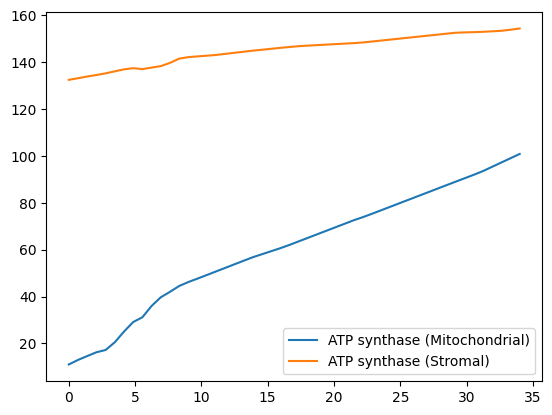

In [35]:
#Plot ATP synthase vs FDHNc activity

plt.plot(fdhnc_x, ATPSm_m, label="ATP synthase (Mitochondrial)")
plt.plot(fdhnc_x, ATPSs_m, label="ATP synthase (Stromal)")
plt.legend()
plt.show()

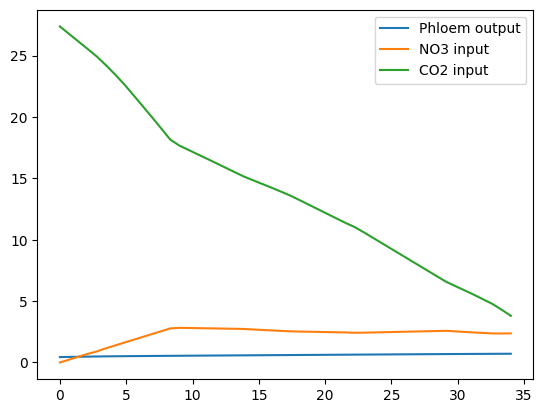

In [36]:

plt.plot(fdhnc_x, phloem_y, label="Phloem output")
plt.plot(fdhnc_x, no3_ex * -1, label="NO3 input")
plt.plot(fdhnc_x, co2_ex * -1, label="CO2 input")
plt.legend()
plt.show()

#Based on the plot below, It shows that CO2 input is more sensitive to FDHNc activity vs NO3 input and
#Phloem input.

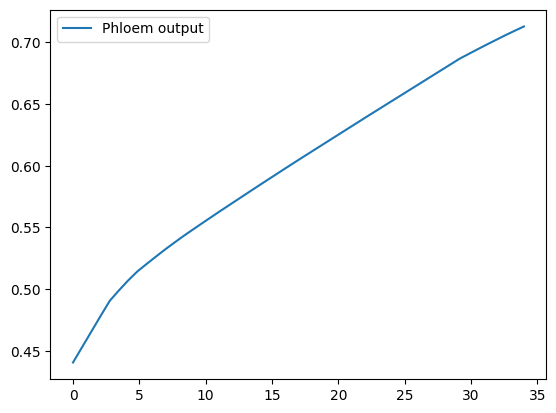

In [37]:

plt.plot(fdhnc_x, phloem_y, label="Phloem output")
plt.legend()
plt.show()

#Formate Dehydrogenase is essential pala in generating nitrate flux due to the generation of Ubiquinone.
#I'll just constrain it to use NH4 instead to prevent futile cycling and other model-related issues



May 10, 2023

After rebalancing my model the model doesn't have erroneous generation anymore. 

July 28, 2023
Flux thru Formate dehydrogenase seems to decrease demand for external CO2. Weird
It also affects phloem input significantly.

It seems to be wrongly encoded as it is present in the 
